In [54]:
%load_ext autoreload
%autoreload 2
import sys
import scirpy as ir
import scanpy as sc
import random
import pandas as pd
import numpy as np
import warnings
import scipy

warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
from multiprocessing import Pool
import powerlaw
import functools
from random import random
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and prepare data

 * Real-world single-cell TCR data (100k cells)

In [55]:
adata = ir.datasets.wu2020()

In [56]:
adata = adata[adata.obs["has_tcr"] == "True", :]

#### Call clonotypes based on sequence identity

In [57]:
ir.pp.tcr_neighbors(
    adata,
    metric="identity",
    receptor_arms="all",
    dual_tcr="primary_only",
    cutoff=0,
    sequence="nt",
)

100%|██████████| 5485675/5485675 [01:28<00:00, 62234.39it/s]
Trying to set attribute `.uns` of view, copying.


In [58]:
ir.tl.define_clonotypes(adata)

* Simulated TCR data (using immuneSIM): 
   - 500k clonotypes
   - some of the sequences are duplicated, resulting in ~460k unique CDR3 nucleotide sequences

In [59]:
tra_seqs = (
    pd.read_csv("../results/01_simulate/cdr3_a.tsv", sep="\t")
    .drop_duplicates("junction")
    .reset_index(drop=True)
)
trb_seqs = (
    pd.read_csv("../results/01_simulate/cdr3_b.tsv", sep="\t")
    .drop_duplicates("junction")
    .reset_index(drop=True)
)

In [60]:
tra_seqs.shape, trb_seqs.shape

((473866, 20), (461617, 20))

# Simulate adata objects

In [61]:
clonotype_sizes = np.array(sorted(adata.obs.groupby("clonotype").size(), reverse=True))

 * The clonotype size distribution follows a power law as we can appreciate on the log-log plot. 
 * However, the power law distribution generated by ImmuneSIM clearly has different characteristics than 
   the one behind the single-cell data



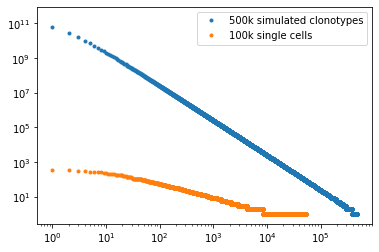

In [62]:
plt.loglog(
    range(len(tra_seqs["counts"])),
    tra_seqs["counts"],
    ".",
    label="500k simulated clonotypes",
)
plt.loglog(
    np.arange(0, len(clonotype_sizes)), clonotype_sizes, ".", label="100k single cells"
)
plt.legend()

 * Therefore, we use the [powerlaw](https://github.com/jeffalstott/powerlaw) package
   to fit the distributions of the single-cell data. 

In [63]:
# skip the first 50, these don't seem to behave power-law like
results = powerlaw.Fit(clonotype_sizes)
print(results.power_law.alpha)
print(results.power_law.xmin)

2.351465158793699
8.0


Calculating best minimal value for power law fit
/home/sturm/.conda/envs/scirpy_runtime_benchmark/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


 * We use the inverse CDF of the powerlaw distribution, to randomly sample from the fitted distribution
     - see also https://stats.stackexchange.com/a/406705/101273

In [64]:
def inv_cdf(x_min, alpha, r):
    """r is a random number between 0 and 1"""
    return x_min * (1 - r) ** (-1 / (alpha - 1))

In [65]:
def get_clonotype_sizes(n_clonotypes, inv_cdf_fit):
    r = np.random.rand(n_clonotypes)
    x_smp = np.round(inv_cdf_fit(r))
    return np.array(sorted(x_smp, reverse=True))

In [66]:
np.random.seed(123)
x_min = 1
r = results.power_law.alpha
inv_cdf_fit = functools.partial(inv_cdf, x_min, r)

x_smp = get_clonotype_sizes(30000, inv_cdf_fit)
x_smp_10 = get_clonotype_sizes(300000, inv_cdf_fit)

* We can now see that the simulated distribution of clonotype sizes is highly similar. 
* The sizes of the largest clonotypes seems to be over-estimated by the simulation. 

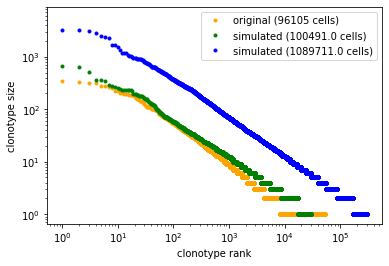

In [73]:
fig, ax = plt.subplots()
ax.loglog(
    np.arange(0, len(clonotype_sizes)),
    clonotype_sizes,
    ".",
    color="orange",
    label=f"original ({np.sum(clonotype_sizes)} cells)",
    rasterized=True
)
ax.loglog(
    np.arange(0, len(x_smp)),
    x_smp,
    ".",
    color="green",
    label=f"simulated ({np.sum(x_smp)} cells)",
    rasterized=True
)
ax.loglog(
    np.arange(0, len(x_smp_10)),
    x_smp_10,
    ".",
    color="blue",
    label=f"simulated ({np.sum(x_smp_10)} cells)",
    rasterized=True
)
ax.set_ylabel("clonotype size")
ax.set_xlabel("clonotype rank")
ax.legend()
fig.savefig("../../figures/runtime_simulation.svg", dpi=300)

 * Generate simulated adata with different sizes

In [68]:
def make_adata(n_clonotypes):
    np.random.seed(42)
    records = []
    clonotype_sizes = get_clonotype_sizes(n_clonotypes, inv_cdf_fit)
    for i, freq in enumerate(clonotype_sizes):
        for _ in range(int(freq)):
            records.append(
                {
                    "TRA_1_cdr3": tra_seqs["junction_aa"][i],
                    "TRA_1_cdr3_nt": tra_seqs["junction"][i],
                    "TRB_1_cdr3": trb_seqs["junction_aa"][i],
                    "TRB_1_cdr3_nt": trb_seqs["junction"][i],
                    "has_tcr": "True",
                }
            )
    tmp_adata = sc.AnnData(
        X=np.empty((len(records), 0)), obs=pd.DataFrame.from_records(records)
    )
    n_cells = tmp_adata.shape[0]
    tmp_adata.write_h5ad(
        "../results/03_simulate_adata/adata_{}.h5ad".format(n_cells), compression="lzf"
    )

In [69]:
sizes = [
    5000,
    10000,
    25000,
    50000,
    75000,
    80000,
    100000,
    125000,
    150000,
    175000,
    200000,
    225000,
    250000,
    275000,
    300000
]
with Pool(len(sizes)) as p:
    p.map(make_adata, sizes)

/home/sturm/.conda/envs/scirpy_runtime_benchmark/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'TRA_1_cdr3' as categorical
... storing 'TRA_1_cdr3_nt' as categorical
... storing 'TRB_1_cdr3' as categorical
... storing 'TRB_1_cdr3_nt' as categorical
... storing 'has_tcr' as categorical
/home/sturm/.conda/envs/scirpy_runtime_benchmark/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'TRA_1_cdr3' as categorical
... storing 'TRA_1_cdr3_nt' as categorical
... storing 'TRB_1_cdr3' as categorical
... storing 'TRB_1_cdr3_nt' as categorical
... storing 'has_tcr' as categorical
/home/sturm/.conda/envs/scirpy_runtime_benchmark/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitMod